## Getting Started

In [1]:
#Load all all of the packages we need.

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cenpy
from cenpy import products

In [2]:
#Load in the SANDAG Database.
sandagvmt=gpd.read_file('San_Diego_Region_SB743_VMT_Maps/San_Diego_Region_SB743_VMT_Maps.shp') 

## Subsetting our data. 

We are concerned about data on the Census Tract level, for the estimated year 2025, using the most recently developed SANDAG model. We also subset for residents and VMT per capita to best match SB 743. 

In [3]:
gdf = sandagvmt[(sandagvmt['geo']=='Census Tract') & (sandagvmt['vmt_year']==2025) & (sandagvmt['version']=='ABM2+ / 2021 RP')&(sandagvmt['vmt_type']=='Residents') & (sandagvmt['vmt_metric']=='Per Capita')]

## Collect Census Data
We are using the Census API because of issues with cenpy. We are reading in variables concerning population, race, and household income.

In [4]:
import requests
#get=NAME,B01001_001E,B01001H_001E,B03002_001,B03002_003,B03002_004,B03002_005,B03002_006,B03002_007,B03002_008,B03002_009,B03002_012,B25119_001
r = requests.get('https://api.census.gov/data/2019/acs/acs5?get=NAME,B01001_001E,B01001H_001E,B03002_001E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E,B25119_001E,B25003_001E,B25003_003E&for=tract&in=state:06+county:073')
censusdata = r.json()
df=pd.DataFrame(censusdata[1:], columns=censusdata[0])
df.head()

NAME B01001_001E B01001H_001E  \
0  Census Tract 165.04, San Diego County, California        6856         3138   
1  Census Tract 170.51, San Diego County, California        5188         2914   
2  Census Tract 170.53, San Diego County, California        3305         2552   
3  Census Tract 170.54, San Diego County, California        5731         4209   
4  Census Tract 170.52, San Diego County, California        5277         2629   

  B03002_001E B03002_004E B03002_005E B03002_006E B03002_007E B03002_008E  \
0        6856         601         121         442           0          58   
1        5188         346           0         737         168           0   
2        3305           3           0         198           0           0   
3        5731          82           9         370           0           0   
4        5277           0          21        1530          23         150   

  B03002_009E B03002_012E B25119_001E B25003_001E B25003_003E state county  \
0         352        2144       46440        2511        1956    06    073   
1         448         575      106161        1988         765    06    073   
2         256         296      155208        1061          70    06    073   
3         252         809      101875        1874         455    06    073   
4         267         657      103336        2221        1184    06    073   

    tract  
0  016504  
1  017051  
2  017053  
3  017054  
4  017052

In [5]:
df['pc_nonHispanicWhite'] = df.B01001H_001E.astype(float) / df.B01001_001E.astype(float) * 100 
ca=df[df['state']=='06']
sd=ca[ca['county']=='073']


In [6]:
sd.rename(columns={"B01001_001E":"total_pop","B01001H_001E":"white_nh","B25119_001E": "median_income", "B03002_001E": "total_race","B03002_004E":"black_nh", "B03002_005E":"native_na_alaska_nh","B03002_006E":"asian_nh","B03002_007E":"native_hi_pi_nh","B03002_008E":"other_race","B03002_009E":"mixed_race","B03002_012E": "total_hisp","B25003_001E":"total_housing", "B25003_003E":"total_renters"}, inplace=True)

sd['pc_Black'] = sd.black_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_amindian'] = sd.native_na_alaska_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_pacislander'] = sd.native_hi_pi_nh.astype(float) / sd.total_pop.astype(float) * 100
sd['pc_asian'] = sd.asian_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_mixedrace'] = sd.mixed_race.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_hispanic'] = sd.total_hisp.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_other_race'] = sd.other_race.astype(float) / sd.total_pop.astype(float) * 100 

sd['pc_renter'] = sd.total_renters.astype(float) / sd.total_housing.astype(float) * 100


In [8]:
#Because we can't use cenpy,and because the SANDAG database does not have a GEOID Field, we need to load the tracts in with geometry
censustractsGDF = sandagvmt=gpd.read_file('San_Diego_Region_SB743_VMT_Maps/tl_2019_06_tract.shp') #Load in the Tracts with geometry so we can Database.

In [161]:
censustractsGDF = censustractsGDF[(censustractsGDF['COUNTYFP']=='073')]

In [162]:
sd.head()

NAME total_pop white_nh  \
0  Census Tract 165.04, San Diego County, California      6856     3138   
1  Census Tract 170.51, San Diego County, California      5188     2914   
2  Census Tract 170.53, San Diego County, California      3305     2552   
3  Census Tract 170.54, San Diego County, California      5731     4209   
4  Census Tract 170.52, San Diego County, California      5277     2629   

  total_race black_nh native_na_alaska_nh asian_nh native_hi_pi_nh other_race  \
0       6856      601                 121      442               0         58   
1       5188      346                   0      737             168          0   
2       3305        3                   0      198               0          0   
3       5731       82                   9      370               0          0   
4       5277        0                  21     1530              23        150   

  mixed_race  ... pc_nonHispanicWhite  pc_Black pc_amindian pc_pacislander  \
0        352  ...           45.770128  8.766044    1.764877       0.000000   
1        448  ...           56.168080  6.669237    0.000000       3.238242   
2        256  ...           77.216339  0.090772    0.000000       0.000000   
3        252  ...           73.442680  1.430815    0.157041       0.000000   
4        267  ...           49.819973  0.000000    0.397953       0.435854   

    pc_asian pc_mixedrace pc_hispanic  pc_other_race            namesplit  \
0   6.446908     5.134189   31.271879       0.845974  Census Tract 165.04   
1  14.205860     8.635312   11.083269       0.000000  Census Tract 170.51   
2   5.990923     7.745840    8.956127       0.000000  Census Tract 170.53   
3   6.456116     4.397138   14.116210       0.000000  Census Tract 170.54   
4  28.993746     5.059693   12.450256       2.842524  Census Tract 170.52   

   pc_renter  
0  77.897252  
1  38.480885  
2   6.597549  
3  24.279616  
4  53.309320  

[5 rows x 27 columns]

In [9]:
sd['namesplit'] = sd['NAME'].str.split(',',expand=True,n=1)[0] #Split the name so we can join!

(628, 18)

In [10]:
print(sd.shape)
print(censustractsGDF.shape)

censustractsGDF = censustractsGDF.merge(sd,left_on='NAMELSAD',right_on='namesplit') #Join the Census Data to the Tract Ge information.

(628, 27)
(8057, 13)


#### The Join

In [11]:
censustractsGDF = censustractsGDF.to_crs('EPSG:2230')
#set the tract geometry to the centroids
censustractsGDF.geometry =censustractsGDF.representative_point() 

#create the spatial join #Spatial Join the SANDAG and Census Data!
joinDf=gpd.sjoin(gdf,censustractsGDF,how='left',predicate='intersects') 

In [12]:
joinDf['pctmean'].describe()

count    626.000000
mean       1.008026
std        0.342556
min        0.270102
25%        0.820923
50%        0.968856
75%        1.131512
max        3.663080
Name: pctmean, dtype: float64

In [ ]:
# List core strategies!

In [ ]:
# Markdown Cell to explain purpose of the regulations and project. Aaron


In [ ]:
# VMT Map/ VMT Category Map
# Demographic and other maps.

In [15]:
#Markdown - Discuss Maps

(628, 59)

In [ ]:
# Scatter Plots and box plots for demographics and VMT!

In [16]:
joinDf.pctmean

3341    0.978482
3342    0.803511
3343    0.832956
3344    0.710646
3345    0.719706
          ...   
3963    0.865798
3964    1.010193
3965    0.475085
3966    0.760476
3967    1.132503
Name: pctmean, Length: 628, dtype: float64

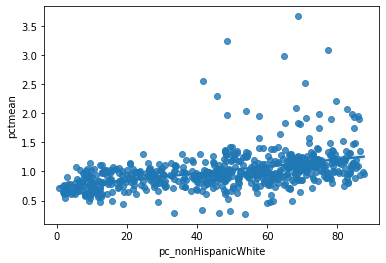

In [17]:
import seaborn as sns
ax = sns.regplot(x="pc_nonHispanicWhite", y="pctmean", data=joinDf) #Not a huge relation #Aaron to clean up. 

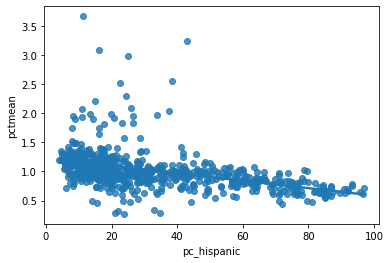

In [18]:
ax = sns.regplot(x="pc_hispanic", y="pctmean", data=joinDf) #Not a huge relation


In [170]:
joinDf.columns 

Index(['OBJECTID', 'version', 'vmt_year', 'year_txt', 'scenario_i', 'geo',
       'geo_id', 'name', 'vmt_type', 'vmt_metric', 'persons', 'vmt',
       'vmt_per_ca', 'pctmean', 'pctmeantxt', 'map_legend', 'SHAPE_Leng',
       'SHAPE_Area', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'GEOID', 'NAME_x', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'NAME_y', 'total_pop', 'white_nh',
       'total_race', 'black_nh', 'native_na_alaska_nh', 'asian_nh',
       'native_hi_pi_nh', 'other_race', 'mixed_race', 'total_hisp',
       'median_income', 'total_housing', 'total_renters', 'state', 'county',
       'tract', 'pc_nonHispanicWhite', 'pc_Black', 'pc_amindian',
       'pc_pacislander', 'pc_asian', 'pc_mixedrace', 'pc_hispanic',
       'pc_other_race', 'namesplit', 'pc_renter'],
      dtype='object')

(0.0, 20.0)

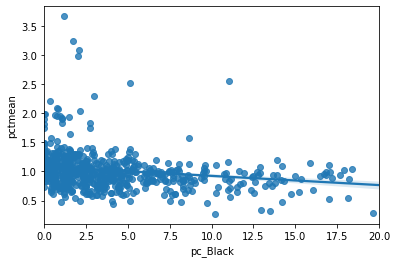

In [171]:
ax = sns.regplot(x="pc_Black", y="pctmean", data=joinDf)
ax.set_xlim(0,20)

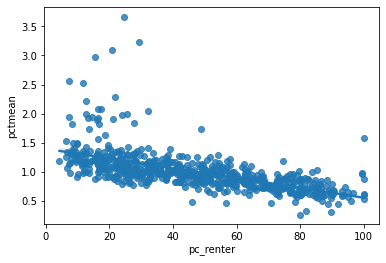

In [187]:
ax = sns.regplot(x="pc_renter", y="pctmean", data=joinDf)

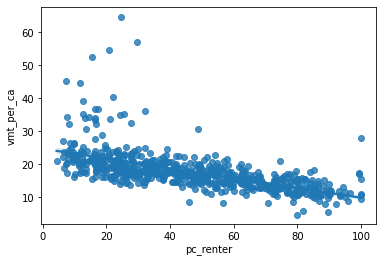

In [188]:
ax = sns.regplot(x="pc_renter", y="vmt_per_ca", data=joinDf)

Text(0.5, 1.0, 'Race by Percentage VMT')

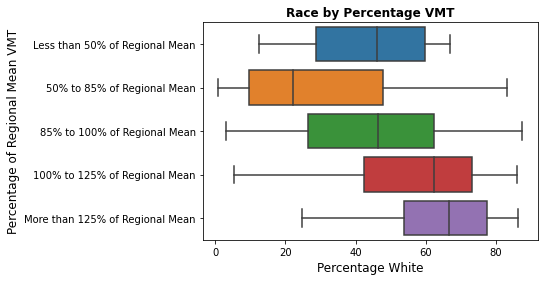

In [172]:
#join.boxplot(by='map_legend',column=['pc_nonHispanicWhite'],grid= False)  #Very Basic Boxplot - Looking at Percent white by categories of data!
#joinDf.sort_values(by='map_legend', ascending=True)
ax = sns.boxplot(y='map_legend', x='pc_nonHispanicWhite',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])
#plt.xticks(ticks=np.arange(0,5, step=1), rotation=70)
plt.xlabel('Percentage White', size='large')
plt.ylabel('Percentage of Regional Mean VMT', size='large')
plt.title("Race by Percentage VMT", weight='bold')

Text(0.5, 1.0, 'Race by Percentage VMT')

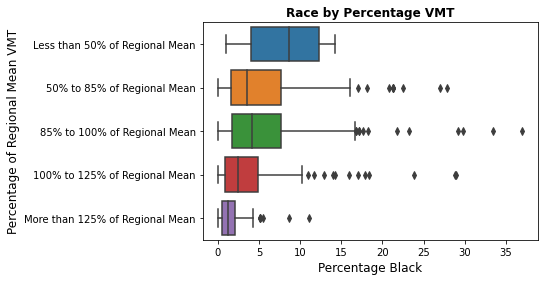

In [190]:
ax = sns.boxplot(y='map_legend', x='pc_Black',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])
#plt.xticks(ticks=np.arange(0,5, step=1), rotation=70)
plt.xlabel('Percentage Black', size='large')
plt.ylabel('Percentage of Regional Mean VMT', size='large')
plt.title("Race by Percentage VMT", weight='bold')

Text(0.5, 1.0, 'Race by Percentage VMT')

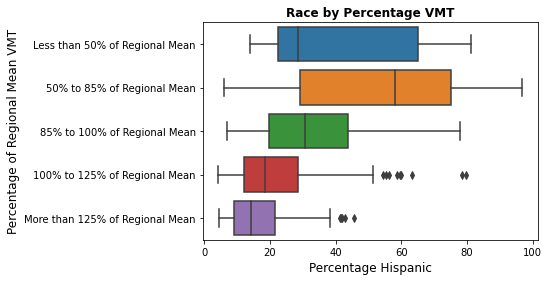

In [191]:
ax = sns.boxplot(y='map_legend', x='pc_hispanic',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])
#plt.xticks(ticks=np.arange(0,5, step=1), rotation=70)
plt.xlabel('Percentage Hispanic', size='large')
plt.ylabel('Percentage of Regional Mean VMT', size='large')
plt.title("Race by Percentage VMT", weight='bold')

Text(0.5, 1.0, 'Renter Status by Percentage VMT')

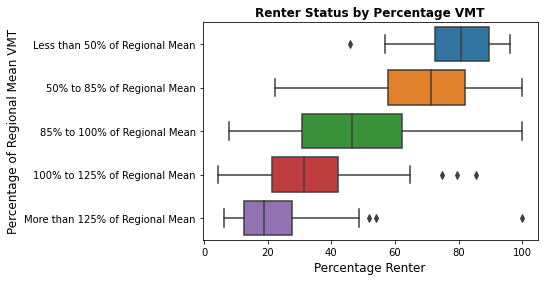

In [193]:
ax = sns.boxplot(y='map_legend', x='pc_renter',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])
#plt.xticks(ticks=np.arange(0,5, step=1), rotation=70)
plt.xlabel('Percentage Renter', size='large')
plt.ylabel('Percentage of Regional Mean VMT', size='large')
plt.title("Renter Status by Percentage VMT", weight='bold')

## K - Means Cluster Analysis


In [210]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

joinDf.dropna(inplace=True)

cols_to_plot = ['vmt','vmt_per_ca','total_pop','median_income','pc_nonHispanicWhite','pc_Black','pc_hispanic','pc_renter']

scaler = preprocessing.StandardScaler().fit(joinDf[cols_to_plot])
df_scaled = pd.DataFrame(scaler.transform(joinDf[cols_to_plot]), 
                         columns=cols_to_plot, index=joinDf.index)
df_scaled.dropna(inplace=True)


kmeans = KMeans(n_clusters=8, random_state=1).fit(df_scaled)


joinDf['cluster_id'] = kmeans.labels_

joinDf.head()

OBJECTID          version  vmt_year year_txt  scenario_i           geo  \
3341      3342  ABM2+ / 2021 RP    2025.0     2025       462.0  Census Tract   
3342      3343  ABM2+ / 2021 RP    2025.0     2025       462.0  Census Tract   
3343      3344  ABM2+ / 2021 RP    2025.0     2025       462.0  Census Tract   
3344      3345  ABM2+ / 2021 RP    2025.0     2025       462.0  Census Tract   
3345      3346  ABM2+ / 2021 RP    2025.0     2025       462.0  Census Tract   

      geo_id  name   vmt_type  vmt_metric  ...  pc_Black  pc_amindian  \
3341   100.0     1  Residents  Per Capita  ...  0.000000     0.000000   
3342   201.0  2.01  Residents  Per Capita  ...  0.528821     0.581703   
3343   202.0  2.02  Residents  Per Capita  ...  0.088067     0.000000   
3344   300.0     3  Residents  Per Capita  ...  5.077305     0.000000   
3345   400.0     4  Residents  Per Capita  ...  5.998421     0.000000   

      pc_pacislander   pc_asian pc_mixedrace pc_hispanic  pc_other_race  \
3341        0.000000   3.621080     3.330100   15.809893        0.00000   
3342        0.000000   3.966155     4.547858    7.403490        0.00000   
3343        0.066050   8.344342     3.302510   13.562307        0.00000   
3344        0.133613   2.786791     2.462302   16.625310        0.00000   
3345        0.000000  11.312812     2.446725   23.257038        0.47356   

              namesplit  pc_renter  cluster_id  
3341     Census Tract 1  11.764706           1  
3342  Census Tract 2.01  49.166667           1  
3343  Census Tract 2.02  57.736820           5  
3344     Census Tract 3  74.234354           5  
3345     Census Tract 4  82.630029           5  

[5 rows x 60 columns]

In [211]:
# code from https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [212]:
#code from lecture 15
def radar_plot(kmeans, df_scaled):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    spoke_labels = [col for col in df_scaled.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(9, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')

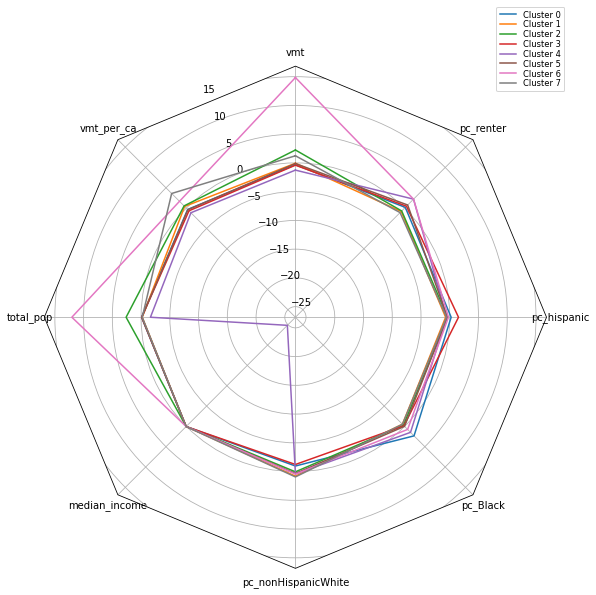

In [213]:
radar_plot(kmeans, df_scaled)

[]

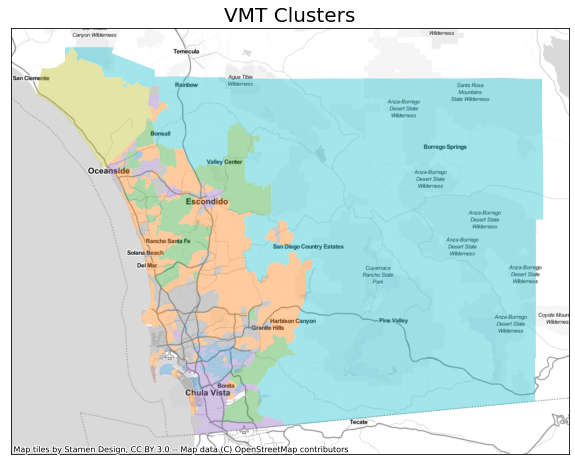

In [214]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10,10))
joinDf.to_crs('EPSG:3857').plot('cluster_id', categorical=True, 
                                   ax=ax, alpha=0.4)

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_title('VMT Clusters', fontsize=20)                           
ax.set_xticks([])
ax.set_yticks([])


In [215]:
joinDf.groupby('cluster_id')['vmt'].mean()

cluster_id
0    7.340713e+04
1    9.239111e+04
2    2.602035e+05
3    6.808669e+04
4    5.461460e+03
5    8.863992e+04
6    1.177638e+06
7    1.870096e+05
Name: vmt, dtype: float64

<AxesSubplot:>

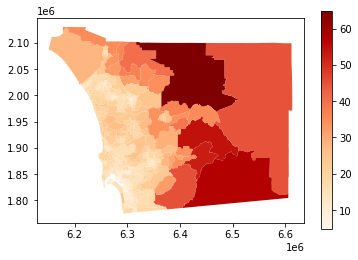

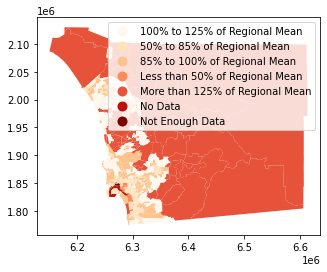

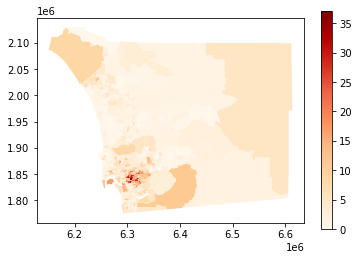

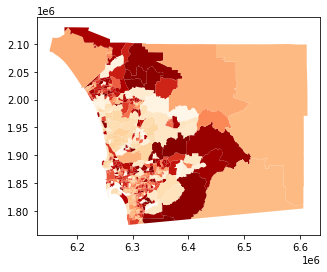

In [20]:
joinDf.plot('vmt_per_ca',  cmap='OrRd', legend=True)
joinDf.plot('map_legend',cmap='OrRd', legend=True)
joinDf.plot('pc_Black',  cmap='OrRd', legend=True)
joinDf.plot('median_income',  cmap='OrRd', legend=False)
#pc_hispanic